In [1]:
import numpy as np
import pandas as pd

In [2]:
import tensorflow as tf

In [3]:
import threading
import os
import cPickle as pickle
import logging
import pprint
import glob
import collections
import struct
import json
logging.basicConfig(format='%(asctime)s %(levelname)s: %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p', level=logging.INFO)


In [4]:
logging.info('abc')

08/17/2017 05:41:30 AM INFO: abc


In [5]:
class GeneratorRunner(object):
    "Custom runner that that runs an generator in a thread and enqueues the outputs."

    def __init__(self, generator, placeholders, enqueue_op, close_op):
        self._generator = generator
        self._placeholders = placeholders
        self._enqueue_op = enqueue_op
        self._close_op = close_op

    def _run(self, sess, coord):
        try:
            while not coord.should_stop():
                try:
                    values = next(self._generator)

                    assert len(values) == len(self._placeholders), \
                        'generator values and placeholders must have the same length'

                    feed_dict = {placeholder: value \
                        for placeholder, value in zip(self._placeholders, values)}
                    sess.run(self._enqueue_op, feed_dict=feed_dict)
                except (StopIteration, tf.errors.OutOfRangeError, tf.errors.DeadlineExceededError, tf.errors.CancelledError) as e:
                    logging.warning ("%s %s %s", self.__class__.__name__, "exception:", str(type(e)))
                    try:
                        sess.run(self._close_op)
                    except Exception:
                        pass
                    return
        except Exception as ex:
            if coord:
                logging.info ("%s %s %s %s", self.__class__.__name__, "request stop from", self._run.__name__, str(ex))
                coord.request_stop(ex)
                pass
            else: 
                raise

    def create_threads(self, sess, coord=None, daemon=False, start=False):
        "Called by `start_queue_runners`."

        thread = threading.Thread(
            target=self._run,
            args=(sess, coord))

        if coord:
            coord.register_thread(thread)

        if daemon:
            thread.daemon = True

        if start:
            thread.start()

        return [thread]

def read_batch_generator(
        generator, dtypes, shapes, batch_size,
        queue_capacity=10000,
        allow_smaller_final_batch=False):
    "Reads values from an generator, queues, and batches."

    assert len(dtypes) == len(shapes), 'dtypes and shapes must have the same length'
    logging.info('shapes: %s, types: %s, batchsize: %d', str(shapes), str(dtypes), batch_size)
    queue = tf.FIFOQueue(
        capacity=queue_capacity,
        dtypes=dtypes,
        shapes=shapes)

    placeholders = [tf.placeholder(dtype, shape) for dtype, shape in zip(dtypes, shapes)]

    enqueue_op = queue.enqueue(placeholders)
    close_op = queue.close(cancel_pending_enqueues=True)
    global_close_ops.append(close_op)
    queue_runner = GeneratorRunner(generator, placeholders, enqueue_op, close_op)
    tf.train.add_queue_runner(queue_runner)

    if allow_smaller_final_batch:
        return queue.dequeue_up_to(batch_size)
    else:
        return queue.dequeue_many(batch_size)    

In [14]:
LEN1=64*2
import Queue
class MemoryGenerator(object):
    def __init__(self, daily_data,attrib_data, epochs=np.inf):
        self.daily_data = daily_data
        self.attrib_data = attrib_data        
        self.shuffle=True
        self.epochs = epochs
        self.N = len(self.daily_data)*10
        self.curr_epoch = 1
        self.curr_i = 0
        self.q = Queue.Queue()
        if self.shuffle:
            self.do_shuffle()
    def __iter__(self):
        return self
    def do_shuffle(self):
        idx = np.random.permutation(range(len(self.daily_data)))
        self.daily_data = self.daily_data[idx]     
        self.attrib_data = self.attrib_data[idx]
    def fill_queue(self):
        for _ in range(100):
            i=int(np.random.random()*len(self.daily_data))
            attrib_row=self.attrib_data[i]
            row=self.daily_data[i]
            len1=LEN1
            len2=60
            j=int(np.random.random()*(len(row)-1))
            part_x=row[:j]
            if len(part_x)>=len1:
                x=part_x[len(part_x)-len1:]
            else:
                x=np.zeros(len1,dtype=np.float32)
                x[len1-len(part_x):]=part_x
            if np.mean(x>0)<0.5: continue
            part_y=row[j:j+len2]
            y=np.zeros(len2,dtype=np.float32)
            y[:len(part_y)]=part_y
            mask=np.zeros(len2,dtype=np.float32)
            mask[:len(part_y)]= (part_y!=0)*1
            self.q.put((x.astype(np.float32),attrib_row.astype(np.float32),np.array(y,dtype=np.float32),mask))
    def __next__(self):
        return self.next()
    def next(self):
        if self.curr_i >= self.N:
            self.curr_i = 0
            self.curr_epoch += 1
            if self.curr_epoch > self.epochs: raise StopIteration
            if self.shuffle: 
                self.do_shuffle()
        if self.q.empty(): self.fill_queue()
        X1,X2, y,mask = self.q.get()
        self.curr_i += 1
        return X1,X2, y,mask 


In [15]:
def make_train_readers(daily_data,attrib_data, nrows=None, batchsize=60):
    print daily_data.shape, attrib_data.shape
    train_generator = MemoryGenerator(daily_data,attrib_data)
    return read_batch_generator(train_generator, [tf.float32, tf.float32, tf.float32, tf.float32], 
                                [(LEN1,), (12,), (60,),(60,)], batchsize, allow_smaller_final_batch=True),train_generator

In [8]:
locales=sorted([u'en', u'ja', u'de', u'fr', u'zh', u'ru', u'es'])
locale_map={v:u for u,v in enumerate(locales)}
locale_map

{u'de': 0, u'en': 1, u'es': 2, u'fr': 3, u'ja': 4, u'ru': 5, u'zh': 6}

In [9]:
access_map={u'all-access':0, u'mobile-web':1, u'desktop':2}
agent_map={u'all-agents':0, u'spider':1}
access_map,agent_map

({u'all-access': 0, u'desktop': 2, u'mobile-web': 1},
 {u'all-agents': 0, u'spider': 1})

In [10]:
def f_map(series, data_map):
    lst=[]
    keys=list(data_map.keys())
    for k in keys:
        lst.append(series.map(lambda u: (u==k)*1))
    df=pd.concat(lst,axis=1)
    df.columns=[series.name+"_"+u for u in keys]
    return df

In [11]:
def make_data():
    import pandas as pd
    csv_path="../input/newtrain_1.csv"
    data = pd.read_csv(csv_path, nrows=None)
    datecols=[u for u in data.columns if u.startswith("20")]
    daily_data=data[datecols].values.astype(np.float32)
    attrib_data=pd.concat([f_map(data.locale,locale_map),
                           f_map(data.agent,agent_map),
                           f_map(data.access,access_map)],axis=1).values.astype(np.float32)    
    print daily_data.shape,attrib_data.shape
    return daily_data,attrib_data

In [12]:
daily_data,attrib_data=make_data()

(145063, 550) (145063, 12)


In [16]:
print np.mean(daily_data==0)
#daily_data += (daily_data==0)*0.1
#print np.mean(daily_data==0)

0.0909115851232


In [17]:
if 0:
    global_close_ops = []
    #daily_data,attrib_data=make_data()
    _, generator=make_train_readers(daily_data,attrib_data)
    a,b,c,d= generator.next()
    print a,b,c,d    
    print a.shape,b.shape,c.shape,d.shape


In [18]:
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>" % size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    from IPython.display import clear_output, Image, display, HTML

    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph' + str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))


In [19]:
def weight_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name=name)

def bias_variable(shape, name):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name=name)

def dense(x, size, scope, with_activation=True):
    if 1:
        with tf.variable_scope(scope):
            w = weight_variable(shape=[int(x.get_shape()[-1]), size], name=None)
            b = bias_variable(shape=[size], name=None)
            h1 = tf.matmul(x, w) + b
            layer=tf.sigmoid(h1) if with_activation else h1
            print layer.get_shape()
    return layer,w,b
from tensorflow.contrib import rnn
def lstm(x,x2, n_hiddens, n_input, n_output, scope):
    if 1:
        with tf.variable_scope(scope):
            x = tf.reshape(x, [-1, n_input])
            x = tf.split(x,n_input,1)
            basic_rnn_cells = [rnn.BasicLSTMCell(n_hidden) for n_hidden in n_hiddens]
            rnn_cell = rnn.MultiRNNCell(basic_rnn_cells)
            outputs, states = rnn.static_rnn(rnn_cell, x, dtype=tf.float32) 
            concat_x=tf.concat([outputs[-1],x2],-1)
            print outputs[-1].get_shape(), concat_x.get_shape()             
            return concat_x

def get_Xy(x_size,x2_size,y_size):
    X = tf.placeholder("float", shape=[None, x_size], name='input_x')
    X2 = tf.placeholder("float", shape=[None, x2_size], name='input_x2')    
    l2_scale = tf.placeholder(tf.float32, name='l2_scale')
    y = tf.placeholder("float", shape=[None, y_size], name='input_y')
    mask = tf.placeholder("float", shape=[None, y_size], name='mask')
    return X,X2, y,mask, l2_scale

In [20]:
class MyModel(object):
    def __init__(self, x_size,y_size, n_hiddens,l2_scale,phase=True ):
        self.phase=phase
        n_hiddens=n_hiddens
        self.graph = tf.Graph()
        self.all_denses = []
        with self.graph.as_default(): 
            self.X, self.X2, self.y, self.mask, self.l2_scale = get_Xy(x_size,12, y_size)
            assert(x_size == self.X.get_shape()[1])
            with tf.variable_scope("nodes"):
                self.X, self.y, self.loss, self.smape \
                     = self.make_model(x_size=x_size, y_size=y_size, n_hiddens=n_hiddens)

            
            with tf.variable_scope('saver'):
                    self.saver = tf.train.Saver()

            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
            with tf.variable_scope('optimizer'):
                with tf.control_dependencies(update_ops):
                    self.optimizer = tf.train.AdamOptimizer()#.minimize(self.loss)
                    gvs = self.optimizer.compute_gradients(self.loss)
                    capped_gvs = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gvs]
                    self.train_op = self.optimizer.apply_gradients(capped_gvs)
        self._session = None    
    @property
    def session(self): 
        if self._session is None:
            config = tf.ConfigProto(log_device_placement=True)
            config.gpu_options.per_process_gpu_memory_fraction = 0.5  # don't hog all vRAM
            self._session = tf.Session(graph=self.graph,config=config)
        return self._session
    
    def close_session(self):
        if self._session is not None:
            self._session.close()
            self._session = None
    def initialize(self, session=None):
        with self.graph.as_default():
            init_op = tf.global_variables_initializer()        
        self.session.run(init_op) 
        return self.session
 
        
    def make_model(self, x_size,y_size, n_hiddens):
        X_raw, y  = self.X, self.y 
        logging.debug ("%s %s", self.__class__.__name__,
                       'input shapes: X={},y={}'.format(X_raw.get_shape(), None if y is None else y.get_shape()))

        h = tf.log(X_raw+1)
        #h=     tf.layers.batch_normalization(h,center=False, scale=True,training=self.phase)
        
        h=lstm(h,self.X2, [n_hiddens[0]], x_size, y_size, 'lstm')
        for i in range(0, len(n_hiddens)):
            n_hidden = n_hiddens[i]
            h, w,b = dense(h, n_hidden,'dense')
            self.all_denses.append((h,w,b))

        logits_sum,_,_=dense(h,y_size,'dense',with_activation=False)
        
        with tf.variable_scope("loss"):
            epsilon = 1e-7        
            l2_loss = 0
            if 1:  # self.l2_scale > 0:
                logging.info('use l2 reg scale %s', str(self.l2_scale))
                for _,w,_ in self.all_denses:
                    l2_loss = l2_loss + tf.reduce_sum(w ** 2)
                l2_loss = l2_loss * self.l2_scale
                self.l2_loss = l2_loss
            if 1:
                predictions = tf.identity(logits_sum, name='prediction')
                float_labels = tf.cast(y, tf.float32)
                
                ratio=predictions/(float_labels+1e-4)
                additional_loss= 0.02*tf.cast(ratio>9,tf.float32)*tf.abs(ratio)\
                    +0.02*tf.cast(predictions<0.0,tf.float32)*tf.abs(predictions)
                additional_loss = tf.reduce_sum(additional_loss*self.mask)/tf.reduce_sum(self.mask)
                this_loss =  tf.abs(predictions-float_labels)/(tf.abs(predictions)+tf.abs(float_labels))
                this_loss=this_loss*self.mask
                this_loss = tf.identity(2* tf.reduce_sum(this_loss)/tf.reduce_sum(self.mask), name='smape')                          
                loss = this_loss + l2_loss+additional_loss

            logging.info ('%s %s %s', self.__class__.__name__, 'logits shape', logits_sum.get_shape())

        return X_raw, y, loss, this_loss
 
    
    def save(self, prefix, ckpt=1):
        checkpoint_name = '{}/model_{}'.format(prefix, 0)
        self.saver.save(self.session, checkpoint_name, global_step=ckpt)

    def load(self, prefix, ckpt=1):
        self.saver.restore(self.session, '{}/model_{}-{}'.format(prefix, self.model_id, ckpt))


In [21]:
if 0:
    tf.reset_default_graph()
    model = MyModel(x_size=5, y_size=2, n_hiddens=[2,2], l2_scale=0.1)
    model.initialize()
    #print [n.op for n in model.graph.as_graph_def().node];
    show_graph(model.graph.as_graph_def())

In [22]:
def svd_orthonormal(shape):
    print(shape)
    if len(shape) < 2:
        raise RuntimeError("Only shapes of length 2 or more are supported.")
    flat_shape = (shape[0], np.prod(shape[1:]))
    a = np.random.standard_normal(flat_shape)
    u, _, v = np.linalg.svd(a, full_matrices=False)
    q = u if u.shape == flat_shape else v
    q = q.reshape(shape)
    return q

def get_activations(model, h, X_batch):
    activations = model.session.run(h, feed_dict={model.X:X_batch})
    return activations

def LSUVinit(model, batch):
    # only these layer classes considered for LSUV initialization; add more if needed    
    margin = 0.1
    max_iter = 10
    layers_inintialized = 0
    for h,w,_ in model.all_denses:
        # avoid small layers where activation variance close to zero, esp. for small batches
        if np.prod(h.get_shape()) < 32:
            print(h, 'too small')
            continue
        logging.info('LSUV initializing' + str(h))
        layers_inintialized += 1
        needed_variance = 1.0
        
        # print ('pre',np.sum(model.session.run(np.abs(w))))
        weights = svd_orthonormal(w.get_shape())
        model.session.run(tf.assign(w, weights))
        # print (model.session.run(w),weights)
        # print ('post',np.sum(model.session.run(np.abs(w))),np.sum(np.abs(weights)))        
        acts1 = get_activations(model, h, batch)
        # print (acts1,needed_variance)
        
        var1 = np.var(acts1)
        iter1 = 0
        logging.info('var1 %f', var1)
        while (abs(needed_variance - var1) > margin):
            if np.abs(np.sqrt(var1)) < 1e-7: break  # avoid zero division
            weights /= np.sqrt(var1) / np.sqrt(needed_variance)
            model.session.run(tf.assign(w, weights))
            acts1 = get_activations(model, h, batch)
            var1 = np.var(acts1)
            iter1 += 1
            # print (acts1)
            logging.info('var1 %f', var1)
            if iter1 > max_iter:
                break
    logging.info('LSUV: total layers initialized %d', layers_inintialized)   
    return model


In [23]:

class BN(object):
    def __init__(self, x_size, y_size, n_hiddens, l2_scale=0.0, prefix='./tmp'):
        self.x_size = x_size
        self.y_size=y_size
        self.n_hiddens = n_hiddens
        self.l2_scale = l2_scale
        self.prefix = prefix
    

    def train_one_epoch(self, n_epoch, sess, model, train_reader,test_reader, coord):
        count = 0
        loss = []; l2_loss = []
        while not coord.should_stop():
            try:
                if  True:
                    X,X2, y,mask = sess.run(train_reader)
                    feed_dict = {model.X:X, model.X2:X2, model.y:y, model.mask:mask, model.l2_scale: self.l2_scale}
                    _, a, aa = model.session.run([model.train_op, model.loss, model.smape], 
                                                    feed_dict=feed_dict)
                    loss.append(a)
                    l2_loss.append(aa)
                    count += len(y)
                    if count % self.net_train_report_intev == 0:

                        logging.info ('[epoch {}][step {}] AVG LOSS: {}, smape: {}'.format(
                            n_epoch, count, np.mean(loss), np.mean(l2_loss)))
                        loss = []; l2_loss = []
                        #self.read_params()

                    if count >= self.net_train_eval_intev:
                        X,X2, y,mask = sess.run(test_reader)
                        feed_dict = {model.X:X, model.X2:X2, model.y:y, model.mask:mask, model.l2_scale: self.l2_scale}
                        a, aa = model.session.run([ model.loss, model.smape], 
                                                    feed_dict=feed_dict)
                        logging.info ('[epoch {}] Valid LOSS: {}, smape: {}'.format(
                            n_epoch, a, aa))
                        return 0
            except tf.errors.OutOfRangeError:
                logging.info (self.__class__.__name__, 'Done with read')
                logging.info (self.__class__.__name__, "request stop from", self.train_one_epoch.__name__)                
                coord.request_stop()
                for o in global_close_ops: sess.run(o)
                return 1                                      
            except:
                raise           
        return 0


    def save_net(self, sess, model, n_epoch):
        model.save(prefix=self.prefix, ckpt=n_epoch)

    def train(self, daily_data,attrib_data, net_round,net_train_report_intev,net_train_eval_intev):
        self.net_train_report_intev=net_train_report_intev
        self.net_train_eval_intev=net_train_eval_intev
        model = MyModel(x_size=self.x_size, y_size=self.y_size, n_hiddens=self.n_hiddens,
                             l2_scale=self.l2_scale)
        model.initialize()
        config = tf.ConfigProto(log_device_placement=True)
        config.gpu_options.per_process_gpu_memory_fraction = 0.5  # don't hog all vRAM
        # config.operation_timeout_in_ms = 10000  # terminate on long hangs
        idx=np.random.permutation(range(len(daily_data)))
        trainidx=idx[:int(len(idx)*0.8)]
        testidx=idx[int(len(idx)*0.8):]
        train_daily_data=daily_data[trainidx]
        train_attrib_data=attrib_data[trainidx]
        test_daily_data=daily_data[testidx]
        test_attrib_data=attrib_data[testidx] 
        print train_daily_data.shape,test_daily_data.shape
        with tf.Session(config=config) as sess:
            train_reader,_ = make_train_readers(train_daily_data,train_attrib_data,batchsize=batch_size,nrows=None)            
            test_reader,_ = make_train_readers(test_daily_data,test_attrib_data,batchsize=batch_size*20,nrows=None)            
            
            coord = tf.train.Coordinator()
            threads = tf.train.start_queue_runners(sess=sess, coord=coord)
            res = None
            try:
                if 0:
                    logging.info('Use LSUV initialization')
                    batch = np.concatenate([sess.run(train_reader)[0] for _ in range(100)])
                    LSUVinit(model, batch)
                for j in range(net_round):
                    logging.info ('[epoch {}] start net training'.format(j))
                    if self.train_one_epoch(j, sess, model, train_reader, test_reader,coord) is None:
                        raise Exception("train error") 
                    self.save_net(sess=sess, model=model, n_epoch=0)
            except:
                raise 
            finally:
                logging.info ('%s %s %s', self.__class__.__name__, "request stop from", self.train.__name__)
                for o in global_close_ops: sess.run(o)                
                coord.request_stop()

            coord.join(threads)
            sess.close()
            model.close_session()
            return 

    def read_params(self):
	try:
	    with open('param.txt') as f:
	        m = json.load(f)
 	    a = m["l2_scale"]
	    if self.l2_scale != a: 
		logging.info("Change l2_scale from %e to %e", self.l2_scale, a)
	     	self.l2_scale = a
	except:
	    logging.error('read params failed')


In [24]:
daily_data.shape

(145063, 550)

In [25]:
l2_scale = 1e-8*0

batch_size = 256

if 0: #test
    n_hiddens=[10]
    net_round=10
    net_train_report_intev=batch_size*10
    net_train_eval_intev=10000
else:
    n_hiddens=[512,512]    
    net_round=200
    net_train_report_intev=batch_size*100
    net_train_eval_intev=batch_size*1000

In [26]:
global_close_ops = []
tf.reset_default_graph()       
model = BN(x_size=LEN1, y_size=60, n_hiddens=n_hiddens, prefix='tmp_pred60_lstm_512_nozero_halfxzero', l2_scale=l2_scale)
model.train(daily_data,attrib_data,  \
           net_round=net_round,  net_train_report_intev=net_train_report_intev,
            net_train_eval_intev=net_train_eval_intev )  

08/17/2017 05:44:31 AM INFO: use l2 reg scale Tensor("l2_scale:0", dtype=float32)
08/17/2017 05:44:31 AM INFO: MyModel logits shape (?, 60)


(?, 512) (?, 524)
(?, 512)
(?, 512)
(?, 60)


08/17/2017 05:44:44 AM INFO: shapes: [(128,), (12,), (60,), (60,)], types: [tf.float32, tf.float32, tf.float32, tf.float32], batchsize: 256
08/17/2017 05:44:44 AM INFO: shapes: [(128,), (12,), (60,), (60,)], types: [tf.float32, tf.float32, tf.float32, tf.float32], batchsize: 5120
08/17/2017 05:44:44 AM INFO: [epoch 0] start net training


(116050, 550) (29013, 550)
(116050, 550) (116050, 12)
(29013, 550) (29013, 12)


08/17/2017 05:45:05 AM INFO: [epoch 0][step 25600] AVG LOSS: 1.49024915695, smape: 1.48580896854
08/17/2017 05:45:19 AM INFO: [epoch 0][step 51200] AVG LOSS: 1.40139186382, smape: 1.3872423172
08/17/2017 05:45:34 AM INFO: [epoch 0][step 76800] AVG LOSS: 1.38557052612, smape: 1.36333560944
08/17/2017 05:45:48 AM INFO: [epoch 0][step 102400] AVG LOSS: 1.37392520905, smape: 1.34461247921
08/17/2017 05:46:03 AM INFO: [epoch 0][step 128000] AVG LOSS: 1.37266302109, smape: 1.33481764793
08/17/2017 05:46:17 AM INFO: [epoch 0][step 153600] AVG LOSS: 1.36324965954, smape: 1.31980836391
08/17/2017 05:46:32 AM INFO: [epoch 0][step 179200] AVG LOSS: 1.3574347496, smape: 1.306666255
08/17/2017 05:46:46 AM INFO: [epoch 0][step 204800] AVG LOSS: 1.35350477695, smape: 1.29757642746
08/17/2017 05:47:01 AM INFO: [epoch 0][step 230400] AVG LOSS: 1.35743939877, smape: 1.29850101471
08/17/2017 05:47:15 AM INFO: [epoch 0][step 256000] AVG LOSS: 1.36212158203, smape: 1.29722940922
08/17/2017 05:47:16 AM INFO

08/17/2017 06:03:09 AM INFO: [epoch 7][step 102400] AVG LOSS: 0.483516007662, smape: 0.482863277197
08/17/2017 06:03:24 AM INFO: [epoch 7][step 128000] AVG LOSS: 0.474418997765, smape: 0.473387151957
08/17/2017 06:03:38 AM INFO: [epoch 7][step 153600] AVG LOSS: 0.475040793419, smape: 0.474159657955
08/17/2017 06:03:52 AM INFO: [epoch 7][step 179200] AVG LOSS: 0.473592072725, smape: 0.472457230091
08/17/2017 06:04:07 AM INFO: [epoch 7][step 204800] AVG LOSS: 0.472616642714, smape: 0.471400946379
08/17/2017 06:04:21 AM INFO: [epoch 7][step 230400] AVG LOSS: 0.46952983737, smape: 0.468604445457
08/17/2017 06:04:35 AM INFO: [epoch 7][step 256000] AVG LOSS: 0.468000233173, smape: 0.467361539602
08/17/2017 06:04:36 AM INFO: [epoch 7] Valid LOSS: 0.469040989876, smape: 0.467923372984
08/17/2017 06:04:37 AM INFO: [epoch 8] start net training
08/17/2017 06:04:54 AM INFO: [epoch 8][step 25600] AVG LOSS: 0.471338927746, smape: 0.470576405525
08/17/2017 06:05:08 AM INFO: [epoch 8][step 51200] AVG 

08/17/2017 06:20:42 AM INFO: [epoch 14][step 153600] AVG LOSS: 0.426745384932, smape: 0.425659954548
08/17/2017 06:20:56 AM INFO: [epoch 14][step 179200] AVG LOSS: 0.424582242966, smape: 0.423087716103
08/17/2017 06:21:10 AM INFO: [epoch 14][step 204800] AVG LOSS: 0.427794963121, smape: 0.427070021629
08/17/2017 06:21:25 AM INFO: [epoch 14][step 230400] AVG LOSS: 0.421677738428, smape: 0.420974195004
08/17/2017 06:21:39 AM INFO: [epoch 14][step 256000] AVG LOSS: 0.427395910025, smape: 0.426213145256
08/17/2017 06:21:39 AM INFO: [epoch 14] Valid LOSS: 0.422945618629, smape: 0.422698616982
08/17/2017 06:21:40 AM INFO: [epoch 15] start net training
08/17/2017 06:21:57 AM INFO: [epoch 15][step 25600] AVG LOSS: 0.427918821573, smape: 0.426898300648
08/17/2017 06:22:11 AM INFO: [epoch 15][step 51200] AVG LOSS: 0.421846777201, smape: 0.421093344688
08/17/2017 06:22:26 AM INFO: [epoch 15][step 76800] AVG LOSS: 0.424394100904, smape: 0.423693925142
08/17/2017 06:22:40 AM INFO: [epoch 15][step 1

08/17/2017 06:38:14 AM INFO: [epoch 21][step 204800] AVG LOSS: 0.409269750118, smape: 0.408516049385
08/17/2017 06:38:28 AM INFO: [epoch 21][step 230400] AVG LOSS: 0.405711889267, smape: 0.405060619116
08/17/2017 06:38:42 AM INFO: [epoch 21][step 256000] AVG LOSS: 0.408275097609, smape: 0.407746016979
08/17/2017 06:38:43 AM INFO: [epoch 21] Valid LOSS: 0.412629544735, smape: 0.411929130554
08/17/2017 06:38:44 AM INFO: [epoch 22] start net training
08/17/2017 06:39:01 AM INFO: [epoch 22][step 25600] AVG LOSS: 0.406313300133, smape: 0.405544996262
08/17/2017 06:39:15 AM INFO: [epoch 22][step 51200] AVG LOSS: 0.409238278866, smape: 0.408556103706
08/17/2017 06:39:30 AM INFO: [epoch 22][step 76800] AVG LOSS: 0.407770812511, smape: 0.406875252724
08/17/2017 06:39:44 AM INFO: [epoch 22][step 102400] AVG LOSS: 0.412417560816, smape: 0.411750644445
08/17/2017 06:39:58 AM INFO: [epoch 22][step 128000] AVG LOSS: 0.406507074833, smape: 0.405824154615
08/17/2017 06:40:12 AM INFO: [epoch 22][step 1

08/17/2017 06:55:48 AM INFO: [epoch 28][step 256000] AVG LOSS: 0.404478043318, smape: 0.403271645308
08/17/2017 06:55:48 AM INFO: [epoch 28] Valid LOSS: 0.412474393845, smape: 0.411421388388
08/17/2017 06:55:50 AM INFO: [epoch 29] start net training
08/17/2017 06:56:07 AM INFO: [epoch 29][step 25600] AVG LOSS: 0.405530005693, smape: 0.404558211565
08/17/2017 06:56:21 AM INFO: [epoch 29][step 51200] AVG LOSS: 0.403022617102, smape: 0.402419954538
08/17/2017 06:56:35 AM INFO: [epoch 29][step 76800] AVG LOSS: 0.403010398149, smape: 0.402453839779
08/17/2017 06:56:49 AM INFO: [epoch 29][step 102400] AVG LOSS: 0.405002683401, smape: 0.404041022062
08/17/2017 06:57:04 AM INFO: [epoch 29][step 128000] AVG LOSS: 0.403549879789, smape: 0.402812182903
08/17/2017 06:57:18 AM INFO: [epoch 29][step 153600] AVG LOSS: 0.404612660408, smape: 0.403695106506
08/17/2017 06:57:32 AM INFO: [epoch 29][step 179200] AVG LOSS: 0.401718586683, smape: 0.401088178158
08/17/2017 06:57:46 AM INFO: [epoch 29][step 2

08/17/2017 07:12:52 AM INFO: [epoch 36] start net training
08/17/2017 07:13:09 AM INFO: [epoch 36][step 25600] AVG LOSS: 0.415990442038, smape: 0.414760321379
08/17/2017 07:13:23 AM INFO: [epoch 36][step 51200] AVG LOSS: 0.412710696459, smape: 0.411652296782
08/17/2017 07:13:38 AM INFO: [epoch 36][step 76800] AVG LOSS: 0.409086823463, smape: 0.408334165812
08/17/2017 07:13:52 AM INFO: [epoch 36][step 102400] AVG LOSS: 0.411098867655, smape: 0.410160034895
08/17/2017 07:14:06 AM INFO: [epoch 36][step 128000] AVG LOSS: 0.409476965666, smape: 0.40869307518
08/17/2017 07:14:20 AM INFO: [epoch 36][step 153600] AVG LOSS: 0.411348879337, smape: 0.410499542952
08/17/2017 07:14:34 AM INFO: [epoch 36][step 179200] AVG LOSS: 0.409823417664, smape: 0.408763468266
08/17/2017 07:14:48 AM INFO: [epoch 36][step 204800] AVG LOSS: 0.406941711903, smape: 0.406176179647
08/17/2017 07:15:02 AM INFO: [epoch 36][step 230400] AVG LOSS: 0.409346818924, smape: 0.408552050591
08/17/2017 07:15:16 AM INFO: [epoch 

08/17/2017 07:30:26 AM INFO: [epoch 43][step 51200] AVG LOSS: 0.399627715349, smape: 0.398788630962
08/17/2017 07:30:40 AM INFO: [epoch 43][step 76800] AVG LOSS: 0.394883334637, smape: 0.393791884184
08/17/2017 07:30:54 AM INFO: [epoch 43][step 102400] AVG LOSS: 0.395914107561, smape: 0.394971758127
08/17/2017 07:31:08 AM INFO: [epoch 43][step 128000] AVG LOSS: 0.395451188087, smape: 0.394684374332
08/17/2017 07:31:22 AM INFO: [epoch 43][step 153600] AVG LOSS: 0.393541753292, smape: 0.39271569252
08/17/2017 07:31:36 AM INFO: [epoch 43][step 179200] AVG LOSS: 0.395845293999, smape: 0.394856452942
08/17/2017 07:31:51 AM INFO: [epoch 43][step 204800] AVG LOSS: 0.394606411457, smape: 0.393730521202
08/17/2017 07:32:05 AM INFO: [epoch 43][step 230400] AVG LOSS: 0.394120186567, smape: 0.39329624176
08/17/2017 07:32:19 AM INFO: [epoch 43][step 256000] AVG LOSS: 0.393245130777, smape: 0.392613232136
08/17/2017 07:32:19 AM INFO: [epoch 43] Valid LOSS: 0.39601495862, smape: 0.394944429398
08/17/

08/17/2017 07:47:59 AM INFO: [epoch 50][step 102400] AVG LOSS: 0.388169676065, smape: 0.387568563223
08/17/2017 07:48:14 AM INFO: [epoch 50][step 128000] AVG LOSS: 0.390673458576, smape: 0.389771014452
08/17/2017 07:48:28 AM INFO: [epoch 50][step 153600] AVG LOSS: 0.391346663237, smape: 0.390573263168
08/17/2017 07:48:42 AM INFO: [epoch 50][step 179200] AVG LOSS: 0.391331255436, smape: 0.390088647604
08/17/2017 07:48:55 AM INFO: [epoch 50][step 204800] AVG LOSS: 0.390962839127, smape: 0.389928668737
08/17/2017 07:49:10 AM INFO: [epoch 50][step 230400] AVG LOSS: 0.388978511095, smape: 0.388009428978
08/17/2017 07:49:24 AM INFO: [epoch 50][step 256000] AVG LOSS: 0.388433158398, smape: 0.38765591383
08/17/2017 07:49:24 AM INFO: [epoch 50] Valid LOSS: 0.39109992981, smape: 0.390455573797
08/17/2017 07:49:26 AM INFO: [epoch 51] start net training
08/17/2017 07:49:42 AM INFO: [epoch 51][step 25600] AVG LOSS: 0.387885332108, smape: 0.386907279491
08/17/2017 07:49:56 AM INFO: [epoch 51][step 5

08/17/2017 08:05:31 AM INFO: [epoch 57][step 153600] AVG LOSS: 0.388917416334, smape: 0.388412058353
08/17/2017 08:05:45 AM INFO: [epoch 57][step 179200] AVG LOSS: 0.388471573591, smape: 0.387413531542
08/17/2017 08:05:59 AM INFO: [epoch 57][step 204800] AVG LOSS: 0.387585759163, smape: 0.386685490608
08/17/2017 08:06:13 AM INFO: [epoch 57][step 230400] AVG LOSS: 0.38710963726, smape: 0.386665165424
08/17/2017 08:06:27 AM INFO: [epoch 57][step 256000] AVG LOSS: 0.386925727129, smape: 0.386261552572
08/17/2017 08:06:28 AM INFO: [epoch 57] Valid LOSS: 0.384244501591, smape: 0.383006364107
08/17/2017 08:06:29 AM INFO: [epoch 58] start net training
08/17/2017 08:06:46 AM INFO: [epoch 58][step 25600] AVG LOSS: 0.386904746294, smape: 0.386417478323
08/17/2017 08:07:00 AM INFO: [epoch 58][step 51200] AVG LOSS: 0.388901948929, smape: 0.388138234615
08/17/2017 08:07:14 AM INFO: [epoch 58][step 76800] AVG LOSS: 0.386260211468, smape: 0.385652512312
08/17/2017 08:07:28 AM INFO: [epoch 58][step 10

08/17/2017 08:22:59 AM INFO: [epoch 64][step 204800] AVG LOSS: 0.383697807789, smape: 0.383191883564
08/17/2017 08:23:13 AM INFO: [epoch 64][step 230400] AVG LOSS: 0.385369986296, smape: 0.384401500225
08/17/2017 08:23:27 AM INFO: [epoch 64][step 256000] AVG LOSS: 0.382079839706, smape: 0.381491839886
08/17/2017 08:23:28 AM INFO: [epoch 64] Valid LOSS: 0.385297954082, smape: 0.384891450405
08/17/2017 08:23:29 AM INFO: [epoch 65] start net training
08/17/2017 08:23:46 AM INFO: [epoch 65][step 25600] AVG LOSS: 0.386668562889, smape: 0.386052131653
08/17/2017 08:24:00 AM INFO: [epoch 65][step 51200] AVG LOSS: 0.385091751814, smape: 0.384595185518
08/17/2017 08:24:15 AM INFO: [epoch 65][step 76800] AVG LOSS: 0.385132819414, smape: 0.384440720081
08/17/2017 08:24:28 AM INFO: [epoch 65][step 102400] AVG LOSS: 0.386342138052, smape: 0.385767906904
08/17/2017 08:24:43 AM INFO: [epoch 65][step 128000] AVG LOSS: 0.386147528887, smape: 0.385359078646
08/17/2017 08:24:57 AM INFO: [epoch 65][step 1

08/17/2017 08:40:26 AM INFO: [epoch 71][step 256000] AVG LOSS: 0.384562313557, smape: 0.384045630693
08/17/2017 08:40:27 AM INFO: [epoch 71] Valid LOSS: 0.379569321871, smape: 0.379000753164
08/17/2017 08:40:28 AM INFO: [epoch 72] start net training
08/17/2017 08:40:45 AM INFO: [epoch 72][step 25600] AVG LOSS: 0.38455119729, smape: 0.384132385254
08/17/2017 08:40:59 AM INFO: [epoch 72][step 51200] AVG LOSS: 0.382902592421, smape: 0.38219845295
08/17/2017 08:41:13 AM INFO: [epoch 72][step 76800] AVG LOSS: 0.384543657303, smape: 0.383933365345
08/17/2017 08:41:27 AM INFO: [epoch 72][step 102400] AVG LOSS: 0.382858455181, smape: 0.382335007191
08/17/2017 08:41:41 AM INFO: [epoch 72][step 128000] AVG LOSS: 0.381340563297, smape: 0.38064044714
08/17/2017 08:41:55 AM INFO: [epoch 72][step 153600] AVG LOSS: 0.382072478533, smape: 0.381345331669
08/17/2017 08:42:09 AM INFO: [epoch 72][step 179200] AVG LOSS: 0.382861942053, smape: 0.381918072701
08/17/2017 08:42:23 AM INFO: [epoch 72][step 2048

08/17/2017 08:57:29 AM INFO: [epoch 79] start net training
08/17/2017 08:57:46 AM INFO: [epoch 79][step 25600] AVG LOSS: 0.405767738819, smape: 0.404937297106
08/17/2017 08:58:00 AM INFO: [epoch 79][step 51200] AVG LOSS: 0.408711850643, smape: 0.40801307559
08/17/2017 08:58:14 AM INFO: [epoch 79][step 76800] AVG LOSS: 0.406797021627, smape: 0.406023830175
08/17/2017 08:58:28 AM INFO: [epoch 79][step 102400] AVG LOSS: 0.407582640648, smape: 0.406881421804
08/17/2017 08:58:42 AM INFO: [epoch 79][step 128000] AVG LOSS: 0.409894108772, smape: 0.408769220114
08/17/2017 08:58:56 AM INFO: [epoch 79][step 153600] AVG LOSS: 0.407422989607, smape: 0.406406700611
08/17/2017 08:59:10 AM INFO: [epoch 79][step 179200] AVG LOSS: 0.406573474407, smape: 0.405958533287
08/17/2017 08:59:24 AM INFO: [epoch 79][step 204800] AVG LOSS: 0.408939003944, smape: 0.407837986946
08/17/2017 08:59:38 AM INFO: [epoch 79][step 230400] AVG LOSS: 0.407182961702, smape: 0.406363576651
08/17/2017 08:59:52 AM INFO: [epoch 

08/17/2017 09:14:59 AM INFO: [epoch 86][step 51200] AVG LOSS: 0.401493489742, smape: 0.40042835474
08/17/2017 09:15:13 AM INFO: [epoch 86][step 76800] AVG LOSS: 0.397557139397, smape: 0.396909475327
08/17/2017 09:15:27 AM INFO: [epoch 86][step 102400] AVG LOSS: 0.399630427361, smape: 0.397859692574
08/17/2017 09:15:42 AM INFO: [epoch 86][step 128000] AVG LOSS: 0.401262283325, smape: 0.400543034077
08/17/2017 09:15:56 AM INFO: [epoch 86][step 153600] AVG LOSS: 0.399508029222, smape: 0.398914515972
08/17/2017 09:16:10 AM INFO: [epoch 86][step 179200] AVG LOSS: 0.399130105972, smape: 0.398378759623
08/17/2017 09:16:24 AM INFO: [epoch 86][step 204800] AVG LOSS: 0.39638698101, smape: 0.395309150219
08/17/2017 09:16:38 AM INFO: [epoch 86][step 230400] AVG LOSS: 0.399375677109, smape: 0.398132205009
08/17/2017 09:16:53 AM INFO: [epoch 86][step 256000] AVG LOSS: 0.396440923214, smape: 0.395528286695
08/17/2017 09:16:53 AM INFO: [epoch 86] Valid LOSS: 0.398571521044, smape: 0.397513389587
08/17

08/17/2017 09:32:27 AM INFO: [epoch 93][step 102400] AVG LOSS: 0.390283167362, smape: 0.389449357986
08/17/2017 09:32:41 AM INFO: [epoch 93][step 128000] AVG LOSS: 0.39269271493, smape: 0.392074555159
08/17/2017 09:32:55 AM INFO: [epoch 93][step 153600] AVG LOSS: 0.392112582922, smape: 0.391530543566
08/17/2017 09:33:09 AM INFO: [epoch 93][step 179200] AVG LOSS: 0.389606714249, smape: 0.388938367367
08/17/2017 09:33:24 AM INFO: [epoch 93][step 204800] AVG LOSS: 0.394146800041, smape: 0.393394291401
08/17/2017 09:33:38 AM INFO: [epoch 93][step 230400] AVG LOSS: 0.3896728158, smape: 0.388921022415
08/17/2017 09:33:52 AM INFO: [epoch 93][step 256000] AVG LOSS: 0.393682867289, smape: 0.392661809921
08/17/2017 09:33:52 AM INFO: [epoch 93] Valid LOSS: 0.386862456799, smape: 0.3863491714
08/17/2017 09:33:54 AM INFO: [epoch 94] start net training
08/17/2017 09:34:10 AM INFO: [epoch 94][step 25600] AVG LOSS: 0.39179238677, smape: 0.391072928905
08/17/2017 09:34:25 AM INFO: [epoch 94][step 51200

08/17/2017 09:49:56 AM INFO: [epoch 100][step 153600] AVG LOSS: 0.388967514038, smape: 0.388341039419
08/17/2017 09:50:09 AM INFO: [epoch 100][step 179200] AVG LOSS: 0.38871306181, smape: 0.387628316879
08/17/2017 09:50:24 AM INFO: [epoch 100][step 204800] AVG LOSS: 0.388894736767, smape: 0.388378977776
08/17/2017 09:50:38 AM INFO: [epoch 100][step 230400] AVG LOSS: 0.387597382069, smape: 0.386629372835
08/17/2017 09:50:52 AM INFO: [epoch 100][step 256000] AVG LOSS: 0.387695550919, smape: 0.386629343033
08/17/2017 09:50:53 AM INFO: [epoch 100] Valid LOSS: 0.38691547513, smape: 0.386313647032
08/17/2017 09:50:54 AM INFO: [epoch 101] start net training
08/17/2017 09:51:11 AM INFO: [epoch 101][step 25600] AVG LOSS: 0.38719522953, smape: 0.386377751827
08/17/2017 09:51:25 AM INFO: [epoch 101][step 51200] AVG LOSS: 0.387855023146, smape: 0.386935889721
08/17/2017 09:51:40 AM INFO: [epoch 101][step 76800] AVG LOSS: 0.385155409575, smape: 0.384500145912
08/17/2017 09:51:54 AM INFO: [epoch 101

08/17/2017 10:07:12 AM INFO: [epoch 107][step 179200] AVG LOSS: 0.381071180105, smape: 0.38041099906
08/17/2017 10:07:26 AM INFO: [epoch 107][step 204800] AVG LOSS: 0.386085808277, smape: 0.385495960712
08/17/2017 10:07:40 AM INFO: [epoch 107][step 230400] AVG LOSS: 0.385047733784, smape: 0.384022980928
08/17/2017 10:07:54 AM INFO: [epoch 107][step 256000] AVG LOSS: 0.383197337389, smape: 0.382548183203
08/17/2017 10:07:55 AM INFO: [epoch 107] Valid LOSS: 0.383625477552, smape: 0.383171856403
08/17/2017 10:07:56 AM INFO: [epoch 108] start net training
08/17/2017 10:08:13 AM INFO: [epoch 108][step 25600] AVG LOSS: 0.384380847216, smape: 0.383450478315
08/17/2017 10:08:28 AM INFO: [epoch 108][step 51200] AVG LOSS: 0.384536445141, smape: 0.383960187435
08/17/2017 10:08:42 AM INFO: [epoch 108][step 76800] AVG LOSS: 0.384555697441, smape: 0.38405379653
08/17/2017 10:08:56 AM INFO: [epoch 108][step 102400] AVG LOSS: 0.387771785259, smape: 0.386198848486
08/17/2017 10:09:10 AM INFO: [epoch 10

08/17/2017 10:24:29 AM INFO: [epoch 114][step 204800] AVG LOSS: 0.382622480392, smape: 0.381712138653
08/17/2017 10:24:43 AM INFO: [epoch 114][step 230400] AVG LOSS: 0.383062452078, smape: 0.382466197014
08/17/2017 10:24:57 AM INFO: [epoch 114][step 256000] AVG LOSS: 0.381730049849, smape: 0.381220817566
08/17/2017 10:24:58 AM INFO: [epoch 114] Valid LOSS: 0.385912030935, smape: 0.385548532009
08/17/2017 10:24:59 AM INFO: [epoch 115] start net training
08/17/2017 10:25:15 AM INFO: [epoch 115][step 25600] AVG LOSS: 0.379572361708, smape: 0.379102438688
08/17/2017 10:25:30 AM INFO: [epoch 115][step 51200] AVG LOSS: 0.384846836329, smape: 0.383714258671
08/17/2017 10:25:44 AM INFO: [epoch 115][step 76800] AVG LOSS: 0.38450884819, smape: 0.383498370647
08/17/2017 10:25:58 AM INFO: [epoch 115][step 102400] AVG LOSS: 0.380837887526, smape: 0.380300372839
08/17/2017 10:26:12 AM INFO: [epoch 115][step 128000] AVG LOSS: 0.383830487728, smape: 0.382771462202
08/17/2017 10:26:27 AM INFO: [epoch 1

08/17/2017 10:41:45 AM INFO: [epoch 121][step 230400] AVG LOSS: 0.380287140608, smape: 0.379776000977
08/17/2017 10:41:59 AM INFO: [epoch 121][step 256000] AVG LOSS: 0.383048146963, smape: 0.382412552834
08/17/2017 10:42:00 AM INFO: [epoch 121] Valid LOSS: 0.381108880043, smape: 0.380659431219
08/17/2017 10:42:01 AM INFO: [epoch 122] start net training
08/17/2017 10:42:19 AM INFO: [epoch 122][step 25600] AVG LOSS: 0.379199594259, smape: 0.37864780426
08/17/2017 10:42:33 AM INFO: [epoch 122][step 51200] AVG LOSS: 0.380869209766, smape: 0.380190819502
08/17/2017 10:42:47 AM INFO: [epoch 122][step 76800] AVG LOSS: 0.380898565054, smape: 0.379917919636
08/17/2017 10:43:01 AM INFO: [epoch 122][step 102400] AVG LOSS: 0.382023394108, smape: 0.381162524223
08/17/2017 10:43:15 AM INFO: [epoch 122][step 128000] AVG LOSS: 0.381202995777, smape: 0.380550682545
08/17/2017 10:43:29 AM INFO: [epoch 122][step 153600] AVG LOSS: 0.380725413561, smape: 0.379597812891
08/17/2017 10:43:43 AM INFO: [epoch 1

08/17/2017 10:58:58 AM INFO: [epoch 128][step 256000] AVG LOSS: 0.380248844624, smape: 0.379573523998
08/17/2017 10:58:59 AM INFO: [epoch 128] Valid LOSS: 0.379213750362, smape: 0.378738433123
08/17/2017 10:59:00 AM INFO: [epoch 129] start net training
08/17/2017 10:59:17 AM INFO: [epoch 129][step 25600] AVG LOSS: 0.379702180624, smape: 0.379086256027
08/17/2017 10:59:30 AM INFO: [epoch 129][step 51200] AVG LOSS: 0.375950694084, smape: 0.375621289015
08/17/2017 10:59:44 AM INFO: [epoch 129][step 76800] AVG LOSS: 0.378799289465, smape: 0.378330618143
08/17/2017 10:59:59 AM INFO: [epoch 129][step 102400] AVG LOSS: 0.377773702145, smape: 0.377183794975
08/17/2017 11:00:13 AM INFO: [epoch 129][step 128000] AVG LOSS: 0.379094809294, smape: 0.37851369381
08/17/2017 11:00:27 AM INFO: [epoch 129][step 153600] AVG LOSS: 0.379537820816, smape: 0.379016309977
08/17/2017 11:00:41 AM INFO: [epoch 129][step 179200] AVG LOSS: 0.380765765905, smape: 0.380122900009
08/17/2017 11:00:56 AM INFO: [epoch 1

08/17/2017 11:15:57 AM INFO: [epoch 135] Valid LOSS: 0.375676512718, smape: 0.37541103363
08/17/2017 11:15:58 AM INFO: [epoch 136] start net training
08/17/2017 11:16:15 AM INFO: [epoch 136][step 25600] AVG LOSS: 0.378322601318, smape: 0.377603024244
08/17/2017 11:16:29 AM INFO: [epoch 136][step 51200] AVG LOSS: 0.377632677555, smape: 0.377075999975
08/17/2017 11:16:43 AM INFO: [epoch 136][step 76800] AVG LOSS: 0.378016710281, smape: 0.37726482749
08/17/2017 11:16:57 AM INFO: [epoch 136][step 102400] AVG LOSS: 0.377133518457, smape: 0.376482695341
08/17/2017 11:17:11 AM INFO: [epoch 136][step 128000] AVG LOSS: 0.376181691885, smape: 0.375569880009
08/17/2017 11:17:25 AM INFO: [epoch 136][step 153600] AVG LOSS: 0.375769913197, smape: 0.375176340342
08/17/2017 11:17:39 AM INFO: [epoch 136][step 179200] AVG LOSS: 0.376168012619, smape: 0.375550121069
08/17/2017 11:17:54 AM INFO: [epoch 136][step 204800] AVG LOSS: 0.379014104605, smape: 0.378595471382
08/17/2017 11:18:08 AM INFO: [epoch 13

08/17/2017 11:32:57 AM INFO: [epoch 143] start net training
08/17/2017 11:33:14 AM INFO: [epoch 143][step 25600] AVG LOSS: 0.376687914133, smape: 0.376218765974
08/17/2017 11:33:28 AM INFO: [epoch 143][step 51200] AVG LOSS: 0.376176327467, smape: 0.375784963369
08/17/2017 11:33:42 AM INFO: [epoch 143][step 76800] AVG LOSS: 0.376903563738, smape: 0.376250296831
08/17/2017 11:33:57 AM INFO: [epoch 143][step 102400] AVG LOSS: 0.375538825989, smape: 0.374736696482
08/17/2017 11:34:11 AM INFO: [epoch 143][step 128000] AVG LOSS: 0.378746390343, smape: 0.378186136484
08/17/2017 11:34:25 AM INFO: [epoch 143][step 153600] AVG LOSS: 0.374988287687, smape: 0.374365270138
08/17/2017 11:34:39 AM INFO: [epoch 143][step 179200] AVG LOSS: 0.375377476215, smape: 0.374862670898
08/17/2017 11:34:53 AM INFO: [epoch 143][step 204800] AVG LOSS: 0.378284305334, smape: 0.377710074186
08/17/2017 11:35:07 AM INFO: [epoch 143][step 230400] AVG LOSS: 0.373559504747, smape: 0.372921794653
08/17/2017 11:35:21 AM IN

08/17/2017 11:50:16 AM INFO: [epoch 150][step 25600] AVG LOSS: 0.375544846058, smape: 0.374880105257
08/17/2017 11:50:30 AM INFO: [epoch 150][step 51200] AVG LOSS: 0.374974012375, smape: 0.37452480197
08/17/2017 11:50:45 AM INFO: [epoch 150][step 76800] AVG LOSS: 0.375698268414, smape: 0.374800384045
08/17/2017 11:50:59 AM INFO: [epoch 150][step 102400] AVG LOSS: 0.376274347305, smape: 0.375633239746
08/17/2017 11:51:13 AM INFO: [epoch 150][step 128000] AVG LOSS: 0.375932604074, smape: 0.375391125679
08/17/2017 11:51:27 AM INFO: [epoch 150][step 153600] AVG LOSS: 0.375248879194, smape: 0.374559819698
08/17/2017 11:51:41 AM INFO: [epoch 150][step 179200] AVG LOSS: 0.375305682421, smape: 0.374602347612
08/17/2017 11:51:55 AM INFO: [epoch 150][step 204800] AVG LOSS: 0.376904219389, smape: 0.376060187817
08/17/2017 11:52:09 AM INFO: [epoch 150][step 230400] AVG LOSS: 0.375131100416, smape: 0.374397367239
08/17/2017 11:52:24 AM INFO: [epoch 150][step 256000] AVG LOSS: 0.373383432627, smape:

08/17/2017 12:07:30 PM INFO: [epoch 157][step 51200] AVG LOSS: 0.375131219625, smape: 0.374738812447
08/17/2017 12:07:43 PM INFO: [epoch 157][step 76800] AVG LOSS: 0.379304021597, smape: 0.377689540386
08/17/2017 12:07:57 PM INFO: [epoch 157][step 102400] AVG LOSS: 0.376922011375, smape: 0.376236647367
08/17/2017 12:08:12 PM INFO: [epoch 157][step 128000] AVG LOSS: 0.374944150448, smape: 0.374525725842
08/17/2017 12:08:26 PM INFO: [epoch 157][step 153600] AVG LOSS: 0.375752449036, smape: 0.375376880169
08/17/2017 12:08:40 PM INFO: [epoch 157][step 179200] AVG LOSS: 0.376189619303, smape: 0.375652849674
08/17/2017 12:08:54 PM INFO: [epoch 157][step 204800] AVG LOSS: 0.37482714653, smape: 0.374224126339
08/17/2017 12:09:08 PM INFO: [epoch 157][step 230400] AVG LOSS: 0.377036124468, smape: 0.376190721989
08/17/2017 12:09:23 PM INFO: [epoch 157][step 256000] AVG LOSS: 0.382146149874, smape: 0.379697293043
08/17/2017 12:09:23 PM INFO: [epoch 157] Valid LOSS: 0.385955393314, smape: 0.3854831

08/17/2017 12:24:46 PM INFO: [epoch 164][step 76800] AVG LOSS: 0.373253643513, smape: 0.372911483049
08/17/2017 12:25:00 PM INFO: [epoch 164][step 102400] AVG LOSS: 0.373359948397, smape: 0.372563481331
08/17/2017 12:25:14 PM INFO: [epoch 164][step 128000] AVG LOSS: 0.373781383038, smape: 0.373200833797
08/17/2017 12:25:28 PM INFO: [epoch 164][step 153600] AVG LOSS: 0.374060660601, smape: 0.373464971781
08/17/2017 12:25:42 PM INFO: [epoch 164][step 179200] AVG LOSS: 0.375693440437, smape: 0.375194132328
08/17/2017 12:25:56 PM INFO: [epoch 164][step 204800] AVG LOSS: 0.374238550663, smape: 0.373266577721
08/17/2017 12:26:10 PM INFO: [epoch 164][step 230400] AVG LOSS: 0.381642580032, smape: 0.380970001221
08/17/2017 12:26:25 PM INFO: [epoch 164][step 256000] AVG LOSS: 0.375676810741, smape: 0.375283658504
08/17/2017 12:26:25 PM INFO: [epoch 164] Valid LOSS: 0.377528816462, smape: 0.376955389977
08/17/2017 12:26:27 PM INFO: [epoch 165] start net training
08/17/2017 12:26:44 PM INFO: [epoc

08/17/2017 12:42:00 PM INFO: [epoch 171][step 102400] AVG LOSS: 0.375252813101, smape: 0.374459117651
08/17/2017 12:42:15 PM INFO: [epoch 171][step 128000] AVG LOSS: 0.373896569014, smape: 0.373343616724
08/17/2017 12:42:29 PM INFO: [epoch 171][step 153600] AVG LOSS: 0.375260770321, smape: 0.374093085527
08/17/2017 12:42:43 PM INFO: [epoch 171][step 179200] AVG LOSS: 0.373482197523, smape: 0.37296590209
08/17/2017 12:42:57 PM INFO: [epoch 171][step 204800] AVG LOSS: 0.377517580986, smape: 0.376767545938
08/17/2017 12:43:11 PM INFO: [epoch 171][step 230400] AVG LOSS: 0.372296333313, smape: 0.371628195047
08/17/2017 12:43:25 PM INFO: [epoch 171][step 256000] AVG LOSS: 0.375504463911, smape: 0.374321252108
08/17/2017 12:43:26 PM INFO: [epoch 171] Valid LOSS: 0.373427838087, smape: 0.372880935669
08/17/2017 12:43:27 PM INFO: [epoch 172] start net training
08/17/2017 12:43:44 PM INFO: [epoch 172][step 25600] AVG LOSS: 0.375719308853, smape: 0.375225424767
08/17/2017 12:43:58 PM INFO: [epoch

08/17/2017 12:59:16 PM INFO: [epoch 178][step 128000] AVG LOSS: 0.37402305007, smape: 0.373391926289
08/17/2017 12:59:30 PM INFO: [epoch 178][step 153600] AVG LOSS: 0.376149445772, smape: 0.375549405813
08/17/2017 12:59:44 PM INFO: [epoch 178][step 179200] AVG LOSS: 0.372672915459, smape: 0.371539980173
08/17/2017 12:59:58 PM INFO: [epoch 178][step 204800] AVG LOSS: 0.371055841446, smape: 0.370567083359
08/17/2017 01:00:12 PM INFO: [epoch 178][step 230400] AVG LOSS: 0.374201476574, smape: 0.373739898205
08/17/2017 01:00:26 PM INFO: [epoch 178][step 256000] AVG LOSS: 0.371771425009, smape: 0.371367573738
08/17/2017 01:00:27 PM INFO: [epoch 178] Valid LOSS: 0.374755948782, smape: 0.374442905188
08/17/2017 01:00:28 PM INFO: [epoch 179] start net training
08/17/2017 01:00:45 PM INFO: [epoch 179][step 25600] AVG LOSS: 0.371760636568, smape: 0.371161967516
08/17/2017 01:01:00 PM INFO: [epoch 179][step 51200] AVG LOSS: 0.372846156359, smape: 0.372295886278
08/17/2017 01:01:14 PM INFO: [epoch 

08/17/2017 01:16:30 PM INFO: [epoch 185][step 153600] AVG LOSS: 0.371817469597, smape: 0.371237903833
08/17/2017 01:16:44 PM INFO: [epoch 185][step 179200] AVG LOSS: 0.373704910278, smape: 0.372995793819
08/17/2017 01:16:58 PM INFO: [epoch 185][step 204800] AVG LOSS: 0.37495803833, smape: 0.374290198088
08/17/2017 01:17:12 PM INFO: [epoch 185][step 230400] AVG LOSS: 0.370548903942, smape: 0.370103299618
08/17/2017 01:17:26 PM INFO: [epoch 185][step 256000] AVG LOSS: 0.372740238905, smape: 0.371990650892
08/17/2017 01:17:27 PM INFO: [epoch 185] Valid LOSS: 0.375677257776, smape: 0.374872863293
08/17/2017 01:17:28 PM INFO: [epoch 186] start net training
08/17/2017 01:17:45 PM INFO: [epoch 186][step 25600] AVG LOSS: 0.371027559042, smape: 0.370576202869
08/17/2017 01:18:00 PM INFO: [epoch 186][step 51200] AVG LOSS: 0.374480485916, smape: 0.373926699162
08/17/2017 01:18:14 PM INFO: [epoch 186][step 76800] AVG LOSS: 0.372779965401, smape: 0.372081041336
08/17/2017 01:18:28 PM INFO: [epoch 1

08/17/2017 01:33:45 PM INFO: [epoch 192][step 179200] AVG LOSS: 0.373597711325, smape: 0.372876524925
08/17/2017 01:33:59 PM INFO: [epoch 192][step 204800] AVG LOSS: 0.370627373457, smape: 0.369936406612
08/17/2017 01:34:13 PM INFO: [epoch 192][step 230400] AVG LOSS: 0.373654514551, smape: 0.373042136431
08/17/2017 01:34:27 PM INFO: [epoch 192][step 256000] AVG LOSS: 0.370305746794, smape: 0.369478404522
08/17/2017 01:34:28 PM INFO: [epoch 192] Valid LOSS: 0.371648907661, smape: 0.370988994837
08/17/2017 01:34:29 PM INFO: [epoch 193] start net training
08/17/2017 01:34:46 PM INFO: [epoch 193][step 25600] AVG LOSS: 0.371096432209, smape: 0.370523869991
08/17/2017 01:35:00 PM INFO: [epoch 193][step 51200] AVG LOSS: 0.372417420149, smape: 0.371999740601
08/17/2017 01:35:14 PM INFO: [epoch 193][step 76800] AVG LOSS: 0.37379732728, smape: 0.373288154602
08/17/2017 01:35:28 PM INFO: [epoch 193][step 102400] AVG LOSS: 0.369181722403, smape: 0.368500947952
08/17/2017 01:35:42 PM INFO: [epoch 1

08/17/2017 01:50:58 PM INFO: [epoch 199][step 204800] AVG LOSS: 0.367994010448, smape: 0.367528647184
08/17/2017 01:51:12 PM INFO: [epoch 199][step 230400] AVG LOSS: 0.369675248861, smape: 0.368827313185
08/17/2017 01:51:26 PM INFO: [epoch 199][step 256000] AVG LOSS: 0.37213498354, smape: 0.371691942215
08/17/2017 01:51:26 PM INFO: [epoch 199] Valid LOSS: 0.367690563202, smape: 0.36711320281
08/17/2017 01:51:28 PM INFO: BN request stop from train
08/17/2017 01:51:28 PM WARNING: GeneratorRunner exception: <class 'tensorflow.python.framework.errors_impl.CancelledError'>
08/17/2017 01:51:28 PM WARNING: GeneratorRunner exception: <class 'tensorflow.python.framework.errors_impl.CancelledError'>


# prediction

In [27]:
sess=tf.Session()

In [28]:
saver = tf.train.import_meta_graph('tmp_pred60_lstm_512_nozero_halfxzero/model_0-0.meta')

In [29]:
saver.restore(sess,tf.train.latest_checkpoint('tmp_pred60_lstm_512_nozero_halfxzero/'))

INFO:tensorflow:Restoring parameters from tmp_pred60_lstm_512_nozero_halfxzero/model_0-0


08/18/2017 12:25:07 AM INFO: Restoring parameters from tmp_pred60_lstm_512_nozero_halfxzero/model_0-0


In [30]:
graph = tf.get_default_graph()

In [31]:
x = graph.get_tensor_by_name("input_x:0")
x2 = graph.get_tensor_by_name("input_x2:0")
l2_scale = graph.get_tensor_by_name("l2_scale:0")
y = graph.get_tensor_by_name("input_y:0")
m=graph.get_tensor_by_name("mask:0")
prediction=graph.get_tensor_by_name("nodes/loss/prediction:0")
loss=graph.get_tensor_by_name('nodes/loss/smape:0')

In [44]:
X=[];X2=[];Y=[];MASK=[]
for _ in range(10000):
    i=int(np.random.random()*len(daily_data))
    attrib_row=attrib_data[i]
    row=daily_data[i]
    len1=128
    len2=60
    j=int(np.random.random()*(len(row)-len1-1))
    xx=row[j:j+len1]
    part_y=row[j+len1:j+len1+len2]
    yy=np.zeros(len2,dtype=np.float32)
    yy[:len(part_y)]=part_y
    mask=np.zeros(len2,dtype=np.float32)
    mask[:len(part_y)]=1
    #ask[:len(part_y)]=part_y>0
    a,aa,b,c= xx.astype(np.float32),attrib_row.astype(np.float32),np.array(yy,dtype=np.float32),mask
    X.append(a),X2.append(aa),Y.append(b),MASK.append(c)

In [45]:
X=np.array(X);X2=np.array(X2);Y=np.array(Y);MASK=np.array(MASK)
X.shape,X2.shape,Y.shape,MASK.shape

((10000, 128), (10000, 12), (10000, 60), (10000, 60))

In [46]:
feed_dict={x:X,x2:X2, y:Y,m:MASK,l2_scale:0}

In [47]:
sess.run(loss,feed_dict=feed_dict)

0.50094742

In [48]:
a=sess.run(prediction,feed_dict=feed_dict)
a=np.abs(a)#-1
print a.shape

(10000, 60)


In [49]:
a.max(),a.min()

(13012.639, 0.097209871)

In [50]:
this_loss =  2*np.abs(a-Y)/(np.abs(a)+np.abs(Y))
print np.sum(this_loss<=0)
this_loss=this_loss*MASK
print this_loss.sum()
this_loss.sum()/MASK.sum() 

0
280671.0


0.50091785

In [51]:
MASK.sum()

560314.0

In [52]:
lst=[]
for i in range(1000):
    u=Y[i]
    v=a[i]
    t=MASK[i]
    lst.append(((2*np.abs(u-v)/(np.abs(u)+np.abs(v)))).mean())
    #lst.append(((2*np.abs(v-u)/(np.abs(u)+np.abs(v)))*t).sum()  )  
lst=np.array(lst)
print np.sum(lst),lst.shape    

631.774 (1000,)


Populating the interactive namespace from numpy and matplotlib
0.631774


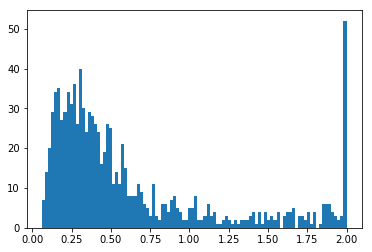

In [53]:
%pylab inline
plt.hist(lst,bins=100);
print np.mean(lst) 

382.5 286.073 0.298084


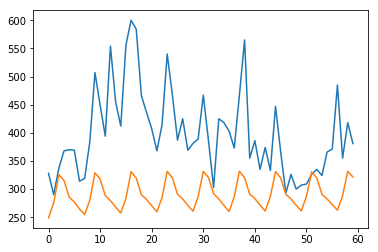

In [54]:
i=123
u=Y[i][:60]
v=a[i]
plt.plot(u)
plt.plot(v)
print np.median(u),np.median(v), (2*np.abs(u-v)/(np.abs(u)+np.abs(v))).mean()

In [55]:
daily_data.shape,attrib_data.shape

((145063, 550), (145063, 12))

In [56]:
daily_test=daily_data[:,-LEN1:]
attrib_test=attrib_data
daily_test.shape,attrib_test.shape

((145063, 128), (145063, 12))

In [57]:
feed_dict={x:daily_test,x2:attrib_test}
predTest=sess.run(prediction,feed_dict=feed_dict)
predTest.shape

(145063, 60)

In [58]:
predTest=np.round(predTest,1)
np.mean(predTest<1)

1.3787113185305694e-06

In [59]:
cols=pd.date_range(pd.datetime.date(datetime.datetime(2017, 1, 1)), periods=60).map(lambda u: u.strftime("%Y-%m-%d"))
idx=pd.read_csv("../input/train_1.csv",usecols=[0])["Page"]
idx.shape

(145063,)

In [60]:
submission=pd.DataFrame(predTest,columns=cols,index=idx)
submission=submission.unstack().reset_index()
submission['name']=submission.apply(lambda r: r['Page']+"_"+r['level_0'],axis=1)
submission=submission.drop(['Page','level_0'],axis=1)
submission.columns=['Visits','name']

In [61]:
submission=submission[["name",'Visits']]
submission.head()

name     Visits
0  2NE1_zh.wikipedia.org_all-access_spider_2017-0...  19.799999
1  2PM_zh.wikipedia.org_all-access_spider_2017-01-01  20.799999
2   3C_zh.wikipedia.org_all-access_spider_2017-01-01   4.600000
3  4minute_zh.wikipedia.org_all-access_spider_201...  13.700000
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...  10.900000

In [62]:
keys=pd.read_csv("../input/key_1.csv",index_col=0)

In [63]:
keys_dict=keys["Id"].to_dict()

In [64]:
submission["Id"]=submission["name"].apply(lambda u:keys_dict[u])

In [65]:
submission.isnull().sum().sum()

0L

In [66]:
submission.head()

name     Visits            Id
0  2NE1_zh.wikipedia.org_all-access_spider_2017-0...  19.799999  ff8c1aade3de
1  2PM_zh.wikipedia.org_all-access_spider_2017-01-01  20.799999  3da6fd5b23c1
2   3C_zh.wikipedia.org_all-access_spider_2017-01-01   4.600000  cd9e83803be4
3  4minute_zh.wikipedia.org_all-access_spider_201...  13.700000  65cd4af0968c
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...  10.900000  75bae1fb2637

In [67]:
submission[["Id","Visits"]].to_csv("../submission/sub_pred_lstm1_60_512_nozero_halfxzero.csv.gz",
                                   index=None, float_format='%.1f', compression="gzip")